# 读取数据

In [16]:
import pandas as pd

btc_data = pd.read_hdf("dataset/binance/BTCUSDT/spot/1m/BTCUSDT_1m_2017-08-17_to_2024-12-23.h5", key="prices")
# 确保数据按时间排序
btc_data = btc_data.sort_values(by="timestamp_start")
print(btc_data.head())

   timestamp_start     open     high  ...  taker_buy_base  taker_buy_quote  ignore
0    1502942400000  4261.48  4261.48  ...        0.075183       320.390851       0
1    1502942460000  4261.48  4261.48  ...        0.000000         0.000000       0
2    1502942520000  4280.56  4280.56  ...        0.261074      1117.542921       0
3    1502942580000  4261.48  4261.48  ...        0.012008        51.171852       0
4    1502942640000  4261.48  4261.48  ...        0.140796       599.999338       0

[5 rows x 12 columns]


## 定义 TD Sequential 指标的计算方法

In [17]:
def calculate_td_sequential(data):
    # 初始化所需列
    data['buy_setup_count'] = 0
    data['sell_setup_count'] = 0
    data['buy_countdown'] = 0
    data['sell_countdown'] = 0

    # Setup Phase
    for i in range(4, len(data)):
        # Buy Setup: Close < Close[4 periods ago]
        if data['close'].iloc[i] < data['close'].iloc[i - 4]:
            data.at[i, 'buy_setup_count'] = data.at[i - 1, 'buy_setup_count'] + 1 if data.at[i - 1, 'buy_setup_count'] < 9 else 1
        else:
            data.at[i, 'buy_setup_count'] = 0

        # Sell Setup: Close > Close[4 periods ago]
        if data['close'].iloc[i] > data['close'].iloc[i - 4]:
            data.at[i, 'sell_setup_count'] = data.at[i - 1, 'sell_setup_count'] + 1 if data.at[i - 1, 'sell_setup_count'] < 9 else 1
        else:
            data.at[i, 'sell_setup_count'] = 0

    # Countdown Phase
    for i in range(len(data)):
        # Buy Countdown: Close <= Low[2 periods ago]
        if data['buy_setup_count'].iloc[i] == 9:
            for j in range(i + 1, len(data)):
                if data['close'].iloc[j] <= data['low'].iloc[j - 2]:
                    data.at[j, 'buy_countdown'] += 1
                    if data.at[j, 'buy_countdown'] >= 13:
                        break

        # Sell Countdown: Close >= High[2 periods ago]
        if data['sell_setup_count'].iloc[i] == 9:
            for j in range(i + 1, len(data)):
                if data['close'].iloc[j] >= data['high'].iloc[j - 2]:
                    data.at[j, 'sell_countdown'] += 1
                    if data.at[j, 'sell_countdown'] >= 13:
                        break

    return data


In [18]:
btc_data = calculate_td_sequential(btc_data)

# 标记有效的 TD9 和 TD13
btc_data['td9_buy'] = (btc_data['buy_setup_count'] == 9).astype(int)
btc_data['td13_buy'] = (btc_data['buy_countdown'] >= 13).astype(int)
btc_data['td9_sell'] = (btc_data['sell_setup_count'] == 9).astype(int)
btc_data['td13_sell'] = (btc_data['sell_countdown'] >= 13).astype(int)

# 忽略包含在 TD13 中的 TD9
btc_data['valid_td9_buy'] = btc_data['td9_buy'] & (btc_data['td13_buy'] == 0)
btc_data['valid_td9_sell'] = btc_data['td9_sell'] & (btc_data['td13_sell'] == 0)

KeyboardInterrupt: 

## 后续 K 线的涨跌计算

In [8]:
def calculate_outcome(data, column):
    outcomes = []
    for idx, value in data[data[column] == 1].iterrows():
        if idx + 1 < len(data):
            next_close = data.iloc[idx + 1]['close']
            current_close = value['close']
            outcomes.append((next_close - current_close) / current_close)
    return outcomes

td9_buy_outcomes = calculate_outcome(btc_data, 'valid_td9_buy')
td13_buy_outcomes = calculate_outcome(btc_data, 'td13_buy')
td9_sell_outcomes = calculate_outcome(btc_data, 'valid_td9_sell')
td13_sell_outcomes = calculate_outcome(btc_data, 'td13_sell')

## 分析涨跌概率及分布

In [13]:
import numpy as np
import matplotlib.pyplot as plt
# 分析涨跌概率及分布
def analyze_outcomes(outcomes, label):
    outcomes = np.array(outcomes)
    positive = np.sum(outcomes > 0) / len(outcomes)
    negative = np.sum(outcomes <= 0) / len(outcomes)
    
    print(f"{label} Following K-Line Statistics:")
    print(f"Probability of Increase: {positive:.2%}")
    print(f"Probability of Decrease: {negative:.2%}")
    
    # 绘制分布
    plt.hist(outcomes, bins=50, alpha=0.75, label=label)
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1.2, label='Zero Return Line')
    plt.title(f"{label} Following K-Line Return Distribution")
    plt.xlabel("Return")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [14]:
# 统计 TD9 和 TD13 出现次数
td9_buy_count = btc_data['valid_td9_buy'].sum()
td13_buy_count = btc_data['td13_buy'].sum()
td9_sell_count = btc_data['valid_td9_sell'].sum()
td13_sell_count = btc_data['td13_sell'].sum()

print(f"TD9 Buy Occurrences: {td9_buy_count}")
print(f"TD13 Buy Occurrences: {td13_buy_count}")
print(f"TD9 Sell Occurrences: {td9_sell_count}")
print(f"TD13 Sell Occurrences: {td13_sell_count}")

TD9 Buy Occurrences: 32
TD13 Buy Occurrences: 20
TD9 Sell Occurrences: 51
TD13 Sell Occurrences: 39


TD9 Buy Following K-Line Statistics:
Probability of Increase: 68.75%
Probability of Decrease: 31.25%


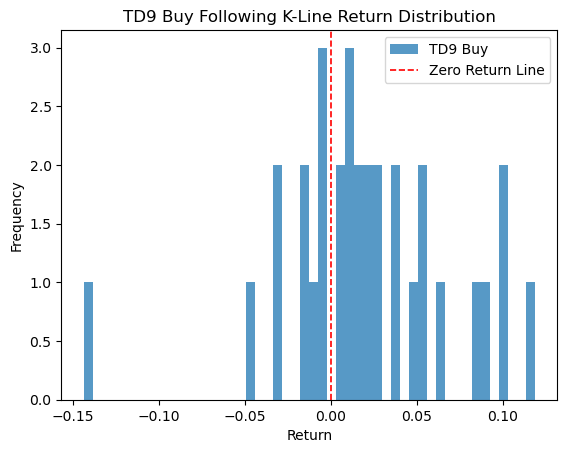

TD13 Buy Following K-Line Statistics:
Probability of Increase: 70.00%
Probability of Decrease: 30.00%


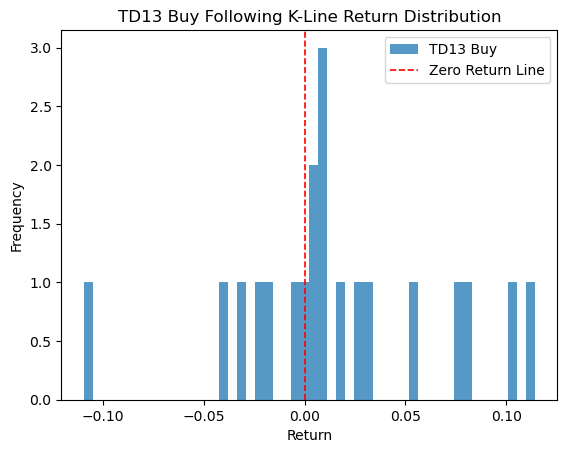

TD9 Sell Following K-Line Statistics:
Probability of Increase: 52.94%
Probability of Decrease: 47.06%


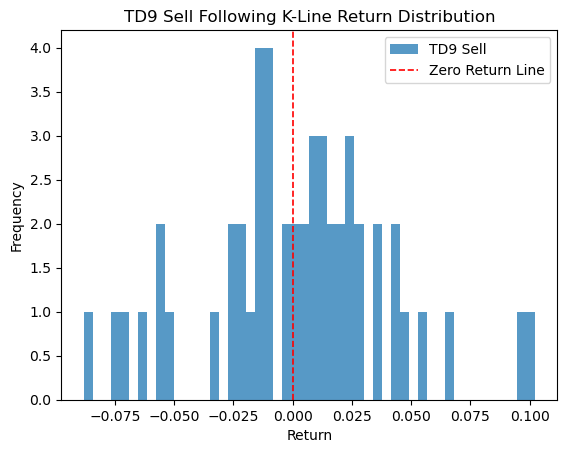

TD13 Sell Following K-Line Statistics:
Probability of Increase: 43.59%
Probability of Decrease: 56.41%


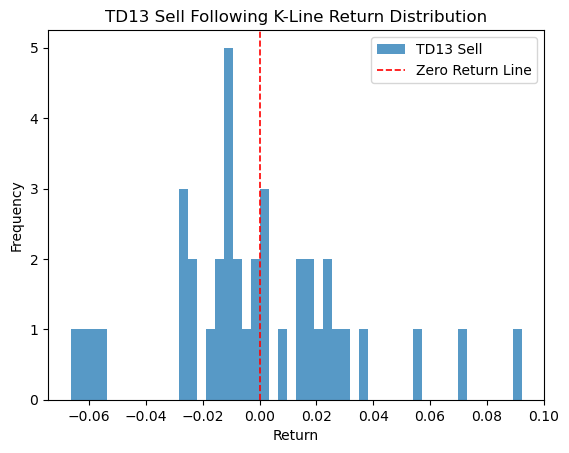

In [15]:
analyze_outcomes(td9_buy_outcomes, "TD9 Buy")
analyze_outcomes(td13_buy_outcomes, "TD13 Buy")
analyze_outcomes(td9_sell_outcomes, "TD9 Sell")
analyze_outcomes(td13_sell_outcomes, "TD13 Sell")